<a href="https://colab.research.google.com/github/sunstrider1999/german_credit/blob/main/german_credit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'german-credit-data-csv:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5324984%2F8847057%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240703%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240703T074950Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dcf5f39a246c2eef8ae7dd07ca1fed871fbfeed4fd9201444ba1ff24ea7ed31f8e7b6e5387f8b8b926be7f37054cc8fa82e29e17de782bc193f428c2aa1354ac0eedb2561fb4868c394cd147c3d5f04b5c246d8bc395b606b49192fe189f567419c964bf6286a8247bb8d11ae48e24d64cbd20d2b667bf548c3759650f23b454fcf67ae9eebe5ec8c0c36fab07078803407721c70a02bd79a9a7b0d220cfb7c8ebe65b9cbf312ae3e19068d3b5bb5dfe83469249bbe8ac62f2cadcf4b9ad76d8a89b4ce9ebbd9038580ece88e6183c2479fdc0d9e0399f2f396639d0e515d20e9d0934e52216917ada380c8e4b381fad99116710cda8f3953d42173dad73ea6c1'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import numpy as mp
import pandas as pd
"""Возраст (числовой)
Пол (текст: мужчина, женщина)
Работа (числовая: 0 - неквалифицированный работник и нерезидент, 1 - неквалифицированный работник и резидент,
2 - квалифицированный, 3 - высококвалифицированный)
Жилье (текст: собственное, арендуемое или бесплатное)
Сберегательные счета (текст - небольшие, умеренные, довольно богатые, rich)
Текущий счет (числовой, в немецких марках)
Сумма кредита (числовая, в немецких марках)
Продолжительность (числовая, в месяцах)
Цель (текст: автомобиль, мебель / оборудование, радио / телевизор, бытовая техника, ремонт, образование, бизнес, отпуск / другие)"""

df = pd.read_csv('/kaggle/input/german-credit-data-csv/german_credit_data.csv',index_col=0)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [ ]:
for col in df.columns:
    if df[col].dtype == 'object':
        # Категориальные признаки
        df[col] = df[col].fillna(df[col].mode().iloc[0])
    else:
        # Числовые признаки
        df[col] = df[col].fillna(df[col].mean())

# Проверка результата
print(df.head())
print(df.isnull().sum())

   Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   67    male    2     own          little           little           1169   
1   22  female    2     own          little         moderate           5951   
2   49    male    1     own          little           little           2096   
3   45    male    2    free          little           little           7882   
4   53    male    2    free          little           little           4870   

   Duration              Purpose  
0         6             radio/TV  
1        48             radio/TV  
2        12            education  
3        42  furniture/equipment  
4        24                  car  
Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
dtype: int64


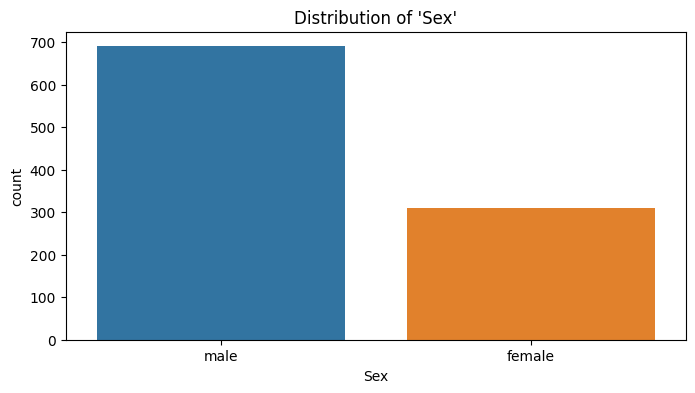

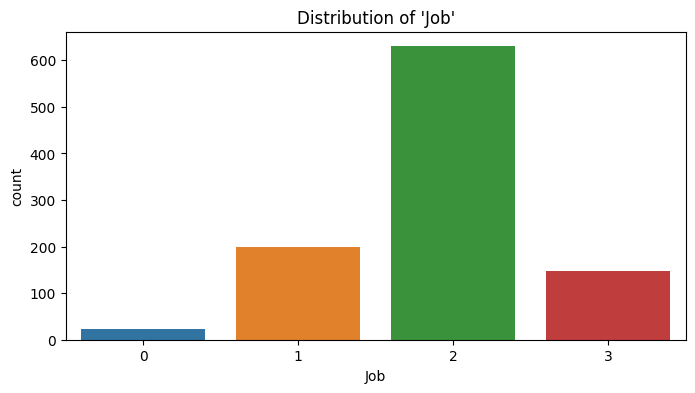

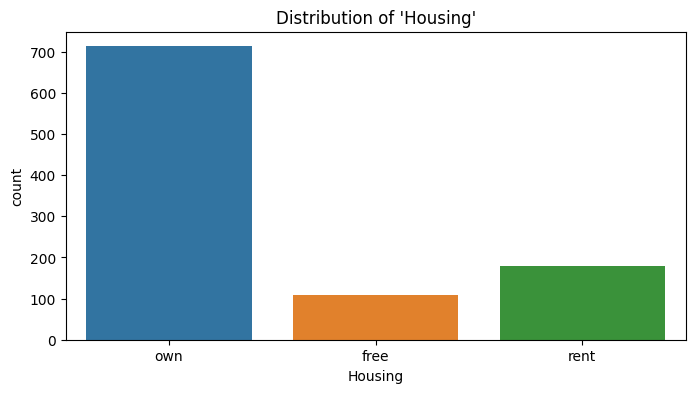

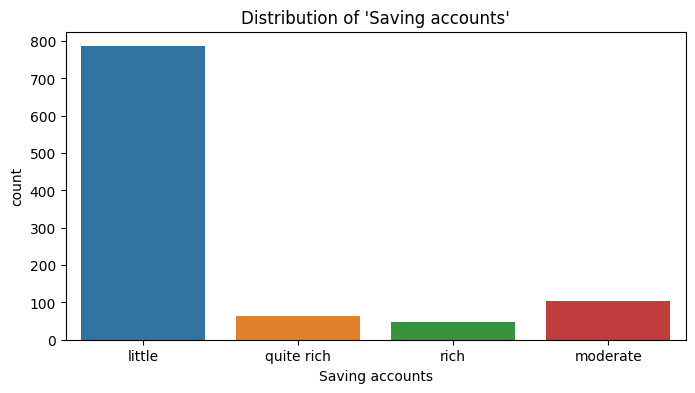

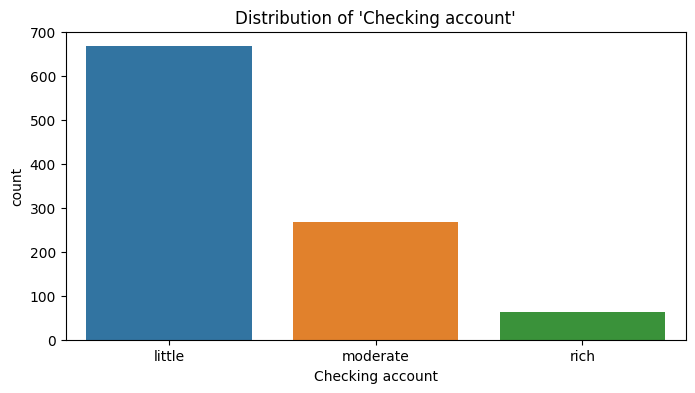

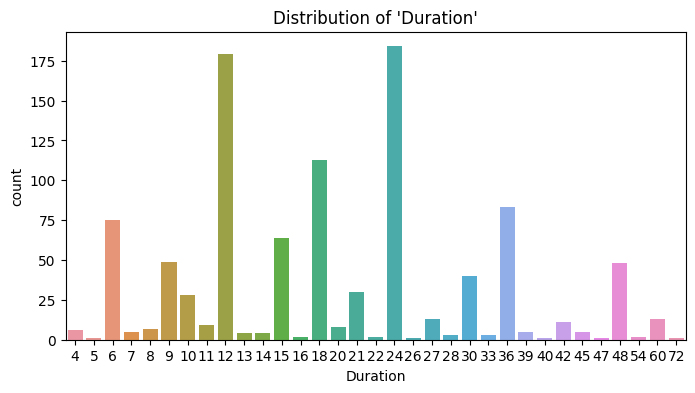

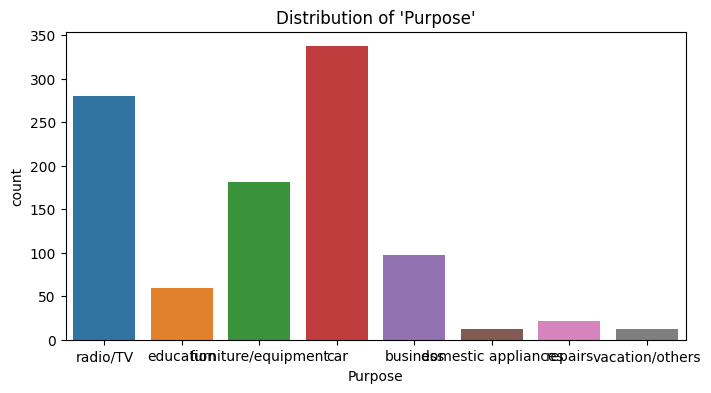

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account','Duration', 'Purpose']:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, data=df)
    plt.title(f"Distribution of '{col}'")
    plt.show()


In [ ]:
cols = ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Duration', 'Purpose', 'Credit amount']
df = df[cols]


In [ ]:
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
# Энкодинг
X = df.drop('Credit amount', axis=1)
y = df['Credit amount']

object_cols = X.select_dtypes(include='object').columns
numeric_cols = X.select_dtypes(exclude='object').columns

cols_for_ohe = [col for col in object_cols if X[col].nunique() < 5]
cols_for_mte = [col for col in object_cols if X[col].nunique() >= 5]
numeric_cols = list(numeric_cols)

cols_for_ohe_idx = [list(X.columns).index(col) for col in cols_for_ohe]
cols_for_mte_idx = [list(X.columns).index(col) for col in cols_for_mte]
numeric_cols_idx = [list(X.columns).index(col) for col in numeric_cols]

t = [('OneHotEncoder',OneHotEncoder(),cols_for_ohe_idx),
     ('TargetEncoder',TargetEncoder(),cols_for_mte),
     ('StandardScaler',StandardScaler(),numeric_cols_idx)]
col_transform = ColumnTransformer(transformers = t)

col_transform.fit(X,y)
X_transformed = col_transform.transform(X)
X_transformed_df = pd.DataFrame(X_transformed, columns=col_transform.get_feature_names_out())
cols_to_drop = ['OneHotEncoder__Sex_female', 'OneHotEncoder__Housing_free', 'OneHotEncoder__Saving accounts_little', 'OneHotEncoder__Checking account_little']
X_transformed_df = X_transformed_df.drop(cols_to_drop, axis=1)
X_transformed_df.head()

,OneHotEncoder__Sex_male,OneHotEncoder__Housing_own,OneHotEncoder__Housing_rent,OneHotEncoder__Saving accounts_moderate,OneHotEncoder__Saving accounts_quite rich,OneHotEncoder__Saving accounts_rich,OneHotEncoder__Checking account_moderate,OneHotEncoder__Checking account_rich,TargetEncoder__Purpose,StandardScaler__Age,StandardScaler__Job,StandardScaler__Duration
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2487.653571,2.766456,0.146949,-1.236478
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2487.653571,-1.191404,0.146949,2.248194
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2886.981873,1.183312,-1.383771,-0.738668
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3066.988971,0.831502,0.146949,1.750384
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3768.192878,1.535122,0.146949,0.256953


In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_transformed_df, y, test_size=0.2, random_state=42)

# Обучаем модель XGBoost с подбором гиперпараметров
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'reg_alpha': [0.0, 0.1, 1.0],
    'reg_lambda': [0.0, 0.1, 1.0]
}

grid_search_xgb = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)

grid_search_xgb.fit(X_train, y_train)

print("Best parameters (XGBoost): ", grid_search_xgb.best_params_)
print("Best RMSE (XGBoost): ", mean_squared_error(y_test, grid_search_xgb.best_estimator_.predict(X_test), squared=False))
print("Best R-squared (XGBoost): ", grid_search_xgb.best_estimator_.score(X_test, y_test))


Best parameters (XGBoost):  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 1.0}
Best RMSE (XGBoost):  1887.8932101432936
Best R-squared (XGBoost):  0.41417787293347363


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed_df, y, test_size=0.2, random_state=42)

# Обучаем модель RandomForestRegressor с подбором гиперпараметров
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2']
}

grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

print("Best parameters (Random Forest): ", grid_search_rf.best_params_)
print("Best RMSE (Random Forest): ", mean_squared_error(y_test, grid_search_rf.best_estimator_.predict(X_test), squared=False))
print("Best R-squared (Random Forest): ", grid_search_rf.best_estimator_.score(X_test, y_test))


Best parameters (Random Forest):  {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}
Best RMSE (Random Forest):  1884.2009627055736
Best R-squared (Random Forest):  0.41646707561927887


In [ ]:
# Проводим A/B-тест
import statsmodels.api as sm
from statsmodels.stats.weightstats import ztest

y_pred_xgb = grid_search_xgb.best_estimator_.predict(X_test)
y_pred_rf = grid_search_rf.best_estimator_.predict(X_test)

rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)

print("RMSE XGBoost:", rmse_xgb)
print("RMSE Random Forest:", rmse_rf)

stat, p_value = ztest(y_pred_xgb, y_pred_rf, value=0, alternative='two-sided')

print("p-value:", p_value)

if p_value < 0.05:
    print("Разница в эффективности моделей статистически значима.")
else:
    print("Разница в эффективности моделей не является статистически значимой.")


RMSE XGBoost: 1887.8932101432936
RMSE Random Forest: 1884.2009627055736
p-value: 0.9387497234575629
Разница в эффективности моделей не является статистически значимой.
